Creating RawArray with float64 data, n_channels=5, n_times=3185966
    Range : 0 ... 3185965 =      0.000 ... 24890.352 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, PZ, T7, T8
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 128.0 Hz
>
Using matplotlib as 2D backend.


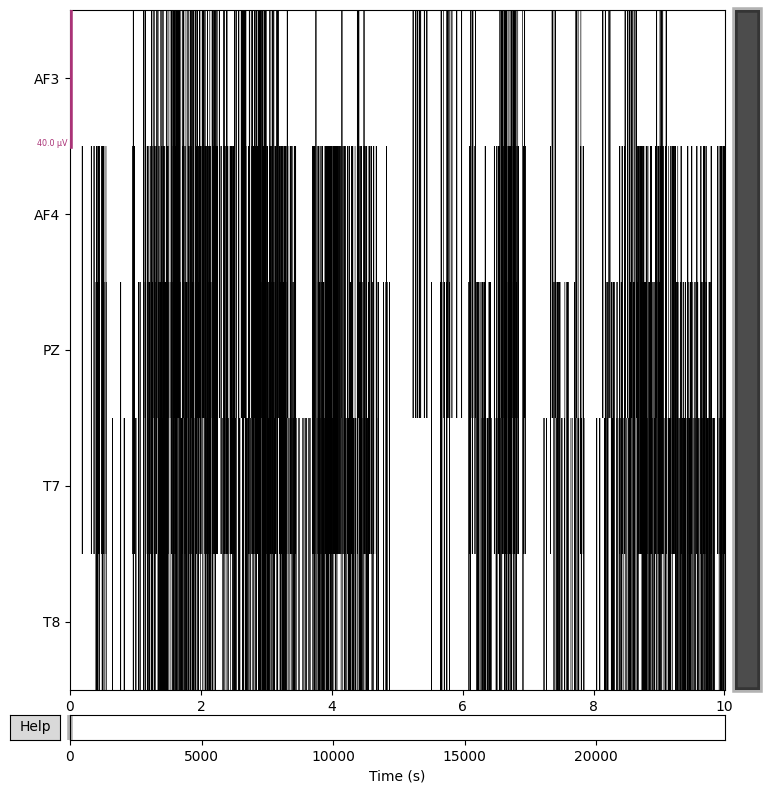

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


/var/folders/qr/lg0pblx11n77b0ktfk5n0qp00000gn/T/ipykernel_68680/2053366384.py:49: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/zaaisvanzyl/Documents/GitHub/neural-interface-ml-pipeline/eeg_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


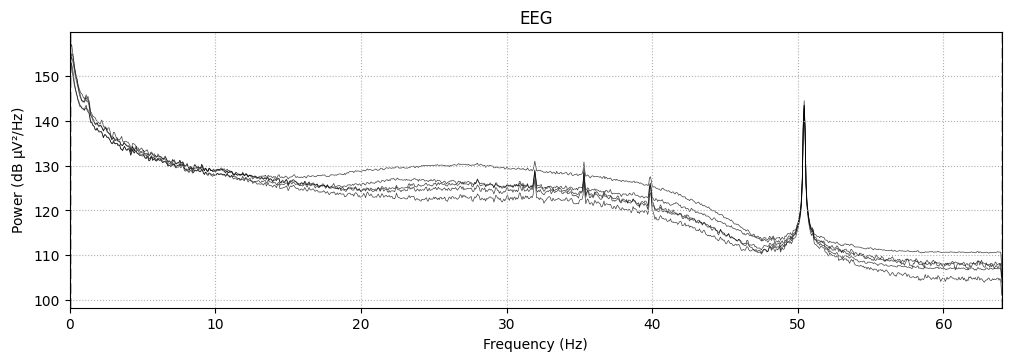

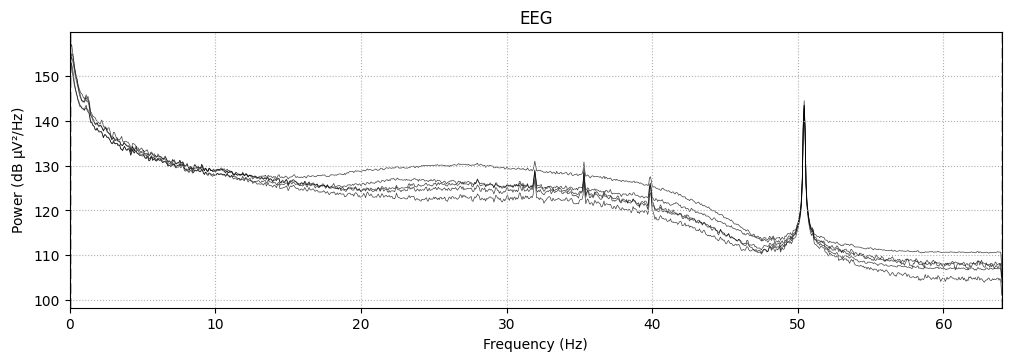

In [1]:
import mne
import numpy as np
import pandas as pd

def load_mindbigdata_txt(filepath):
    df = pd.read_csv(filepath, sep='\t', header=None,
                     names=['id', 'event_id', 'device', 'channel', 'code', 'size', 'data'])
    
    # Convert data strings to arrays
    df['data'] = df['data'].apply(lambda x: np.array([float(val) for val in x.split(',')]))
    
    # Get unique event_ids
    unique_events = df['event_id'].unique()
    
    # Get parameters from first trial
    sfreq = df['size'].iloc[0] / 2  # Size represents 2 seconds of data
    ch_names = sorted(df['channel'].unique())  # Get unique channel names
    
    # Reshape data into (n_channels, n_timepoints * n_trials)
    all_data = []
    for ch in ch_names:
        ch_data = np.concatenate(df[df['channel'] == ch]['data'].values)
        all_data.append(ch_data)
    data = np.array(all_data)
    
    # Create info object
    info = mne.create_info(
        ch_names=ch_names,
        sfreq=sfreq,
        ch_types=['eeg'] * len(ch_names)
    )
    
    # Create Raw object
    raw = mne.io.RawArray(data, info)
    
    # Create events array
    events = np.zeros((len(unique_events), 3), dtype=int)
    events[:, 0] = np.arange(0, len(unique_events) * 256, 256)  # Sample indices
    events[:, 2] = df.groupby('event_id')['code'].first().values  # Event codes
    
    return raw, events, data, df

raw, events, data, df = load_mindbigdata_txt('../data/MindBigData-IN-v1.06.txt')

print(raw.info)

raw.plot()

raw.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (6.602 s)



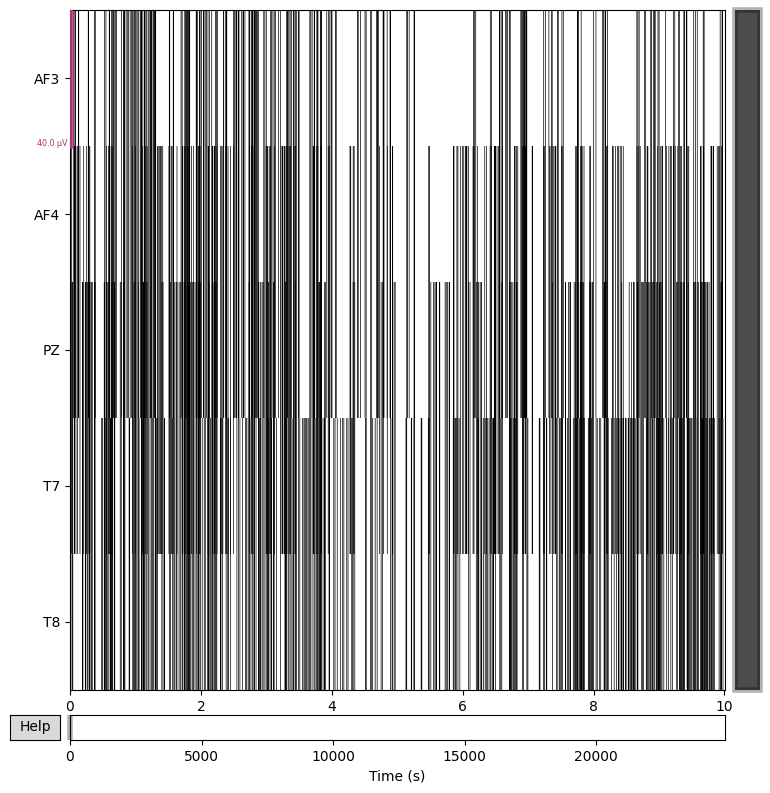

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


/var/folders/qr/lg0pblx11n77b0ktfk5n0qp00000gn/T/ipykernel_68680/4188184818.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/zaaisvanzyl/Documents/GitHub/neural-interface-ml-pipeline/eeg_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


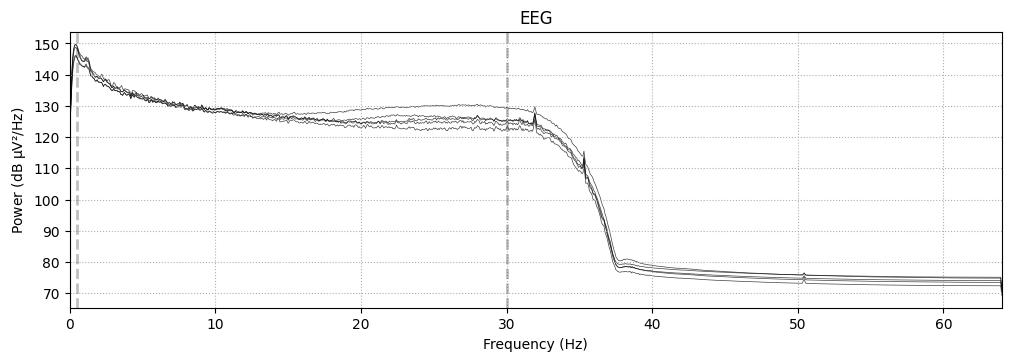

In [2]:
raw = raw.copy().filter(l_freq=0.5, h_freq=30, fir_design='firwin')
raw.plot()

raw.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



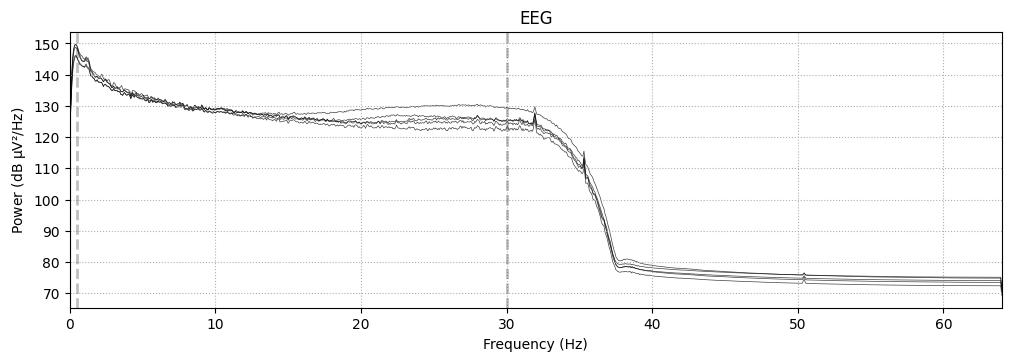

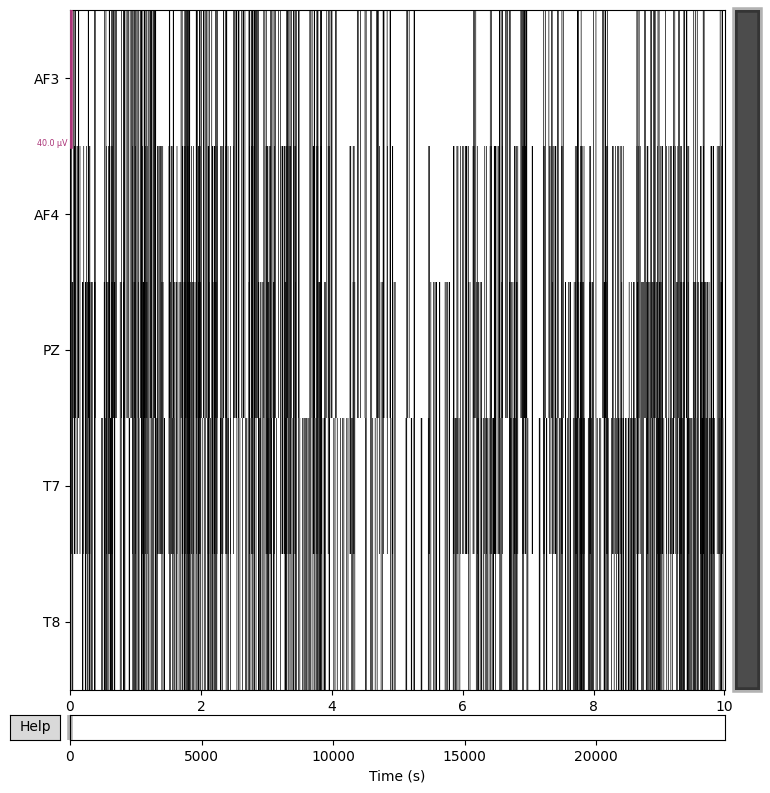

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


/var/folders/qr/lg0pblx11n77b0ktfk5n0qp00000gn/T/ipykernel_68680/154686354.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/zaaisvanzyl/Documents/GitHub/neural-interface-ml-pipeline/eeg_env/lib/python3.11/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


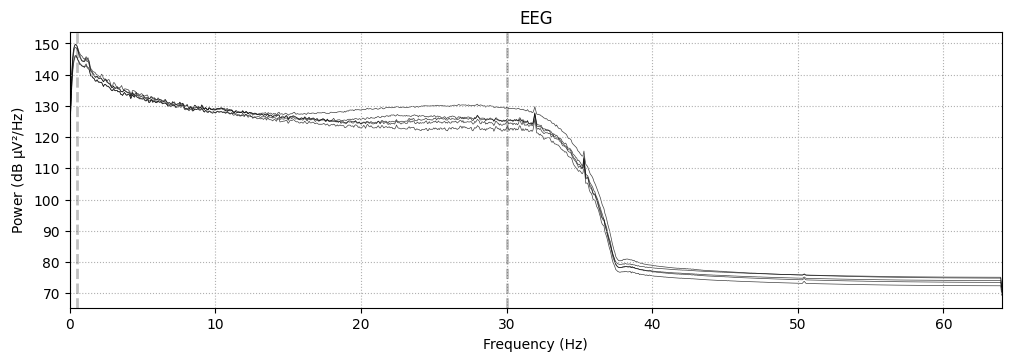

In [3]:
raw = raw.copy().notch_filter(freqs=50.0, fir_design='firwin')

raw.plot()

raw.compute_psd().plot()

In [4]:
# raw.info['bads'] = []
# raw.info['bads'] += mne.preprocessing.find_bad_channels_maxwell(raw, h_freq=30)

# raw = raw.copy().interpolate_bads(reset_bads=True)

# raw.plot()

# raw.compute_psd().plot()

In [5]:
# ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
# ica.fit(raw)

# eog_indices, eog_scores = ica.find_bads_eog(raw, measure='correlation')

# ica.exclude = eog_indices

# raw_clean = ica.apply(raw.copy())

In [6]:
raw = raw.copy().set_eeg_reference('average', projection=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [7]:
n_samples = len(df)
events = np.zeros((n_samples, 3), dtype=int)
events[:, 0] = np.arange(n_samples)
events[:, 2] = df['code'].values

event_id = {f'digit_{i}': i for i in range(10)}

epochs = mne.Epochs(raw, events, event_id=event_id, 
                   tmin=-0.2, tmax=0.8,
                   baseline=(None, 0), preload=True)

print("Shape of raw data:", raw.get_data().shape)
print("Number of samples in df:", len(df))
print("Shape of events array:", events.shape)

Not setting metadata
65250 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 65250 events and 129 original time points ...
26 bad epochs dropped
Shape of raw data: (5, 3185966)
Number of samples in df: 65250
Shape of events array: (65250, 3)


In [8]:
epochs = epochs.copy().apply_baseline(baseline=(None, 0))


Applying baseline correction (mode: mean)


In [9]:
data = epochs.get_data()
mean = data.mean(axis=2, keepdims=True)
std = data.std(axis=2, keepdims=True)
data_normalized = (data - mean) / std
epochs_normalized = mne.EpochsArray(data_normalized, info=epochs.info, events=epochs.events, event_id=epochs.event_id)

Not setting metadata
65224 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [10]:
from mne.decoding import CSP
import numpy as np
from sklearn.preprocessing import StandardScaler

# Get the data
data = epochs.get_data()

# Reshape for scaling (combine trials and time points)
orig_shape = data.shape
data_2d = data.reshape(orig_shape[0], -1)

# Scale the data
scaler = StandardScaler()
data_2d_scaled = scaler.fit_transform(data_2d)

# Reshape back
data_scaled = data_2d_scaled.reshape(orig_shape)

# Verify data is clean
print("\nAfter scaling:")
print("NaN count:", np.isnan(data_scaled).sum())
print("Inf count:", np.isinf(data_scaled).sum())
print("Min value:", np.min(data_scaled))
print("Max value:", np.max(data_scaled))

# Apply CSP
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit(data_scaled, epochs.events[:, -1])
features = csp.transform(data_scaled)


After scaling:
NaN count: 0
Inf count: 0
Min value: -63.4077449417717
Max value: 70.61790573152835
Computing rank from data with rank=None
    Using tolerance 4.3 (2.2e-16 eps * 5 dim * 3.9e+15  max singular value)
    Estimated rank (data): 5
    data: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Estimating class=4 covariance using EMPIRICAL
Done.
Estimating class=5 covariance using EMPIRICAL
Done.
Estimating class=6 covariance using EMPIRICAL
Done.
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.


In [11]:
noise_level = 0.01
noise = np.random.normal(0, noise_level, features.shape)
features_augmented = features + noise

In [12]:
shift_seconds = 0.05
sfreq = raw.info['sfreq']
shift_samples = int(shift_seconds * sfreq)
data = epochs.get_data()
data_shifted = np.roll(data, shift_samples, axis=2)
epochs = mne.EpochsArray(data_shifted, info=epochs.info, events=epochs.events, event_id=epochs.event_id)

Not setting metadata
65224 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [13]:
## Define labels for CSP
labels = epochs.events[:, 2]

In [14]:
features_final = np.vstack((features, features_augmented))
labels_final = np.hstack((labels, labels))

print(f"Features shape: {features_final.shape}")
print(f"Labels shape: {labels_final.shape}")

Features shape: (130448, 4)
Labels shape: (130448,)


In [1]:
import tensorflow as tf
from keras import layers, models

In [2]:
import tensorflow as tf
from keras import layers, models

def EEGNet(nb_classes, Chans, Samples, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout'):
    print("Initializing EEGNet model...")
    if dropoutType == 'SpatialDropout2D':
        drop = layers.SpatialDropout2D
    else:
        drop = layers.Dropout

    input1 = layers.Input(shape=(Chans, Samples, 1))
    print("Input layer created.")

    block1 = layers.Conv2D(F1, (1, kernLength), padding='same',
                          input_shape=(Chans, Samples, 1),
                          use_bias=False)(input1)
    print("Block 1 Conv2D layer created.")
    block1 = layers.BatchNormalization(axis=3)(block1)
    print("Block 1 BatchNormalization layer created.")
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False,
                                    depth_multiplier=D,
                                    depthwise_constraint=tf.keras.constraints.MaxNorm(1.))(block1)
    print("Block 1 DepthwiseConv2D layer created.")
    block1 = layers.BatchNormalization(axis=3)(block1)
    print("Block 1 second BatchNormalization layer created.")
    block1 = layers.Activation('elu')(block1)
    print("Block 1 Activation layer created.")
    block1 = drop(dropoutRate)(block1)
    print("Block 1 Dropout layer created.")

    block2 = layers.SeparableConv2D(F2, (1, 16),
                                    use_bias=False, padding='same')(block1)
    print("Block 2 SeparableConv2D layer created.")
    block2 = layers.BatchNormalization(axis=3)(block2)
    print("Block 2 BatchNormalization layer created.")
    block2 = layers.Activation('elu')(block2)
    print("Block 2 Activation layer created.")
    block2 = drop(dropoutRate)(block2)
    print("Block 2 Dropout layer created.")

    flatten = layers.AveragePooling2D((1, 8))(block2)
    print("AveragePooling2D layer created.")
    flatten = layers.Dropout(dropoutRate)(flatten)
    print("Dropout layer created.")
    flatten = layers.Flatten()(flatten)
    print("Flatten layer created.")

    dense = layers.Dense(nb_classes, name='dense',
                         kernel_constraint=tf.keras.constraints.MaxNorm(0.25))(flatten)
    print("Dense layer created.")
    softmax = layers.Activation('softmax', name='softmax')(dense)
    print("Softmax layer created.")

    print("EEGNet model created successfully.")
    return models.Model(inputs=input1, outputs=softmax)

nb_classes = 10
Chans = 5
Samples = 12

print("Creating EEGNet model instance...")
model = EEGNet(nb_classes=nb_classes, Chans=Chans, Samples=Samples, dropoutRate=0.5)

print("Compiling the model...")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model summary:")
model.summary()

Creating EEGNet model instance...
Initializing EEGNet model...
Input layer created.
Block 1 Conv2D layer created.
Block 1 BatchNormalization layer created.
Block 1 DepthwiseConv2D layer created.
Block 1 second BatchNormalization layer created.
Block 1 Activation layer created.
Block 1 Dropout layer created.
Block 2 SeparableConv2D layer created.
Block 2 BatchNormalization layer created.
Block 2 Activation layer created.
Block 2 Dropout layer created.
AveragePooling2D layer created.
Dropout layer created.
Flatten layer created.
Dense layer created.
Softmax layer created.
EEGNet model created successfully.
Compiling the model...
Model summary:


/Users/zaaisvanzyl/Documents/GitHub/neural-interface-ml-pipeline/eeg_ml/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 12, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 12, 8)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 12, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 12, 16)      │            80 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 12, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 12, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 12, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 12, 16)      │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 12, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 12, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 12, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 1, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,434 (5.60 KB)

 Trainable params: 1,354 (5.29 KB)

 Non-trainable params: 80 (320.00 B)